### MaskRCNN to detection objects
In this script, we are going do image object detection from the street-level images. We will not working on running the pre-trained MaskRCNN model to detection objects and using new labeled data to fine-tune the model to detection new object.

Your homework today is to conduct the labeling work youself and detect a new object based on the pre-trained MaskRCNN.

By Xiaojiang Li, UPenn

Ref:https://github.com/matterport/Mask_RCNN

### Setting Up Your Python Environment

In [ ]:
import torch
import torchvision
print(torch.__version__)       # Should show 2.5.0+cu121
print(torchvision.__version__) # Should show 0.16.0+cu121

2.6.0+cu124
0.21.0+cu124


In [ ]:
%%capture
# Install PyTorch with CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install additional dependencies
!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

# Install package for creating visually distinct colormaps
!pip install distinctipy

# Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

### Importing the Required Dependencies

In [ ]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# Import tqdm for progress bar
from tqdm.auto import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

device, dtype

(device(type='cuda'), torch.float32)

### Preapare the training and testing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from glob import glob
from pathlib import Path
import pandas as pd

dataset_path = Path('/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/green_images_Diamond_bar_Labelme')

def get_img_files(dataset_path):
    return dataset_path.glob('**/*.jpg')

annotation_file_paths = list(dataset_path.glob('*.json'))

img_dict = {file.stem: file for file in get_img_files(dataset_path)}

print(f"Number of Images: {len(img_dict)}")

pd.DataFrame.from_dict(img_dict, orient='index').head(3)

Number of Images: 120


0
2028746107282244  /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/green_images_Diamond_bar_Labelme/2028746107282244.jpg
2220535774749563  /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/green_images_Diamond_bar_Labelme/2220535774749563.jpg
2247574212062568  /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/green_images_Diamond_bar_Labelme/2247574212062568.jpg

#### Get Image Annotations

In [ ]:
from tqdm import tqdm
import os
import pandas as pd

# Step 1: Verify dataset path and files
print("Dataset path exists:", dataset_path.exists())
annotation_file_paths = list(dataset_path.glob('**/*.json'))  # Recursive search
print("Found JSON files:", len(annotation_file_paths))

# Step 2: Validate file format
if annotation_file_paths:
    test_json_path = annotation_file_paths[0]
    try:
        test_df = pd.read_json(test_json_path, orient='index').transpose()
        print("Sample JSON content:\n", test_df.head())
    except Exception as e:
        print("JSON parsing failed:", e)
else:
    print("Error: No JSON files found!")

# Step 3: Merge data with safety checks
if annotation_file_paths:
    # Load all JSON files
    cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))
    annotation_df = pd.concat(cls_dataframes, ignore_index=False)

    # Correct index generation
    annotation_df['index'] = annotation_df['imagePath'].apply(
        lambda x: os.path.splitext(os.path.basename(x))[0]  # Extract filename without extension
    )
    annotation_df = annotation_df.set_index('index')

    # Verify key alignment
    missing_keys = set(img_dict.keys()) - set(annotation_df.index)
    if missing_keys:
        print(f"Warning: {len(missing_keys)} keys missing from annotations, e.g.: {list(missing_keys)[:5]}")

    # Safe filtering
    valid_keys = annotation_df.index.intersection(img_dict.keys())
    annotation_df = annotation_df.loc[valid_keys]

    print("Merged data sample:")
    print(annotation_df.head(1))
else:
    print("Cannot proceed: No valid JSON files found")

Dataset path exists: True
Found JSON files: 120
Sample JSON content:
   version flags  \
0   5.2.1    {}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

100%|██████████| 120/120 [00:02<00:00, 46.79it/s]

Merged data sample:
                 version flags  \
index                            
1939042322940038   5.2.1    {}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Get image classes, sometimes we may get several categories

In [ ]:
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [ ]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

0
0  green_tree
1       shrub
2       grass

Visualize the class distribution

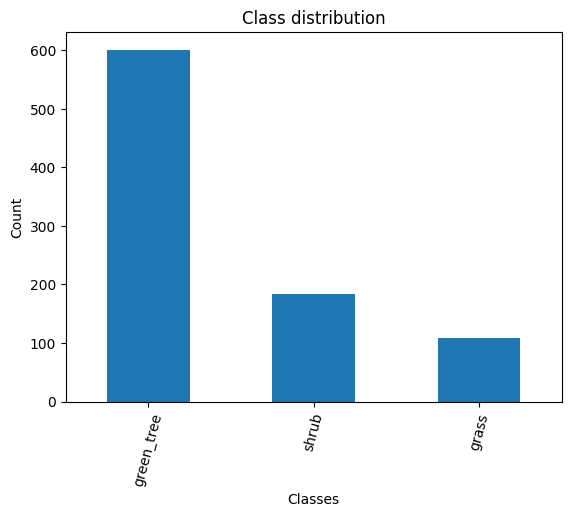

In [ ]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names, rotation=75)  # Set the x-axis tick labels
plt.show()

Add a background class

In [ ]:
# Prepend a `background` class to the list of class names
class_names = [cls for cls in class_names if cls != "background"]
class_names = ['background'] + class_names

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

0
0  background
1  green_tree
2       shrub
3       grass

Generate a color map

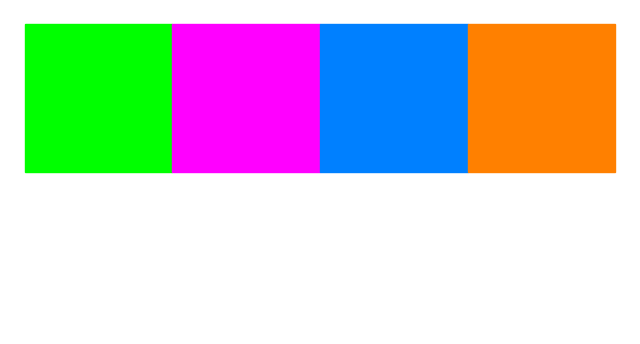

In [ ]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

In [ ]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")


The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


Define the bounding box annotation function

In [ ]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

Load a sample image

In [ ]:
# Step 1: Filter out system files when building img_dict
img_dict = {
    f.stem: str(f)
    for f in dataset_path.glob('**/*')
    if (
        f.is_file() and
        not f.name.startswith('._') and  # Exclude macOS metadata files
        '__MACOSX' not in str(f) and     # Exclude macOS system folder
        f.suffix.lower() in {'.jpg', '.jpeg', '.png'}  # Validate image formats
    )
}

# Step 2: Add safe file access with validation
try:
    # Verify index range first
    if len(img_dict) < 17:
        raise IndexError("Not enough valid images in dictionary")

    file_id = list(img_dict.keys())[16]
    file_path = img_dict[file_id]

    # Multi-layer validation
    if not Path(file_path).exists():
        raise FileNotFoundError(f"Path not exist: {file_path}")

    if not file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        raise ValueError(f"Invalid image format: {file_path}")

    # Safe image opening
    with Image.open(file_path) as img:
        sample_img = img.convert('RGB')
        print(f"Image Dimensions: {sample_img.size}")
        sample_img.show()

except Exception as e:
    print(f"Error: {str(e)}")
    # Implement fallback logic here if needed

Image Dimensions: (1024, 512)


Inspect the corresponding annotation data

In [ ]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

2058106234330279
version                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Define a function to convert segmentation polygons to images

In [ ]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)

    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

Annotate sample image

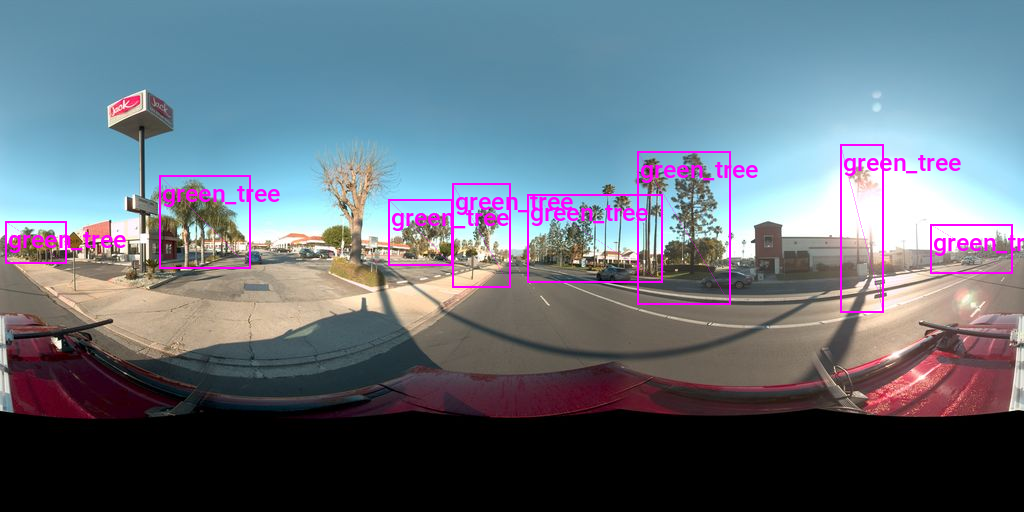

In [ ]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]

# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]

# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img),
    masks=masks,
    alpha=0.3,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=bboxes,
    labels=labels,
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)


### Load MaskRCNN model

In [ ]:
# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type, put the data to GPU devices
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'


Let use this pretrained model for object detction

In [ ]:
import os

print("Current working directory:", os.getcwd())

Current working directory: /content


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


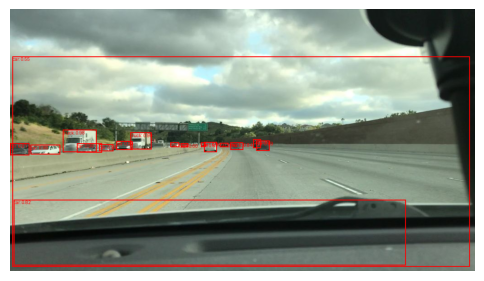

In [ ]:
import torch
import os, os.path
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from torchvision import transforms

# Load the pre-trained model and set it to evaluation mode
model = maskrcnn_resnet50_fpn_v2(pretrained=True)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## The maskrcnn_resnet50_fpn_v2 model in PyTorch, which is trained on the COCO (Common Objects in Context) dataset, can detect 80 different object categories. Here’s the full list of categories:
# Define the COCO class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'TV', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# replace "deeplearn-city/treepedia-workshop" by your own drive path
gsv_img = "/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/green_images_Diamond_bar_Labelme/1980091985479995.jpg"
os.path.exists(gsv_img)


# Load and preprocess the image
image_path = gsv_img  # Replace with your image path
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).to(device)

# Perform object detection
with torch.no_grad():
    predictions = model([image_tensor])

# Set a confidence threshold
confidence_threshold = 0.5

# Convert the image to a drawable format
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

# Optional: Load a font (if you have one available in Colab or local)
# font = ImageFont.truetype("path/to/font.ttf", size=15) # Uncomment if you have a TTF font

# Iterate through detections and draw bounding boxes
for idx, (box, score, label) in enumerate(zip(predictions[0]["boxes"], predictions[0]["scores"], predictions[0]["labels"])):
    if score >= confidence_threshold:
        # Get bounding box coordinates
        x_min, y_min, x_max, y_max = box.cpu().numpy()

        # Draw the bounding box
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)

        # Get the label name and confidence score
        label_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        text = f"{label_name}: {score:.2f}"

        # Draw the label
        draw.text((x_min, y_min), text, fill="red")  # Optional: use `font=font` if a font is loaded

# Display the image with bounding boxes
plt.figure(figsize=(6, 6))
plt.imshow(image_with_boxes)
plt.axis("off")
plt.show()

Summarizing the Model

In [ ]:
test_inp = torch.randn(1, 3, 256, 256).to(device)
summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

/usr/local/lib/python3.11/dist-packages/torchtnt/utils/module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


Type # Parameters # Trainable Parameters Size (bytes) Forward FLOPs
0  MaskRCNN       46.4 M                 46.1 M        185 M         311 G

#### Prepare your own label object and fine-tune th emodel

In [ ]:
# Get the list of image IDs
img_keys = list(img_dict.keys())

# Shuffle the image IDs
random.shuffle(img_keys)

# Define the percentage of the images that should be used for training
train_pct = 0.8
val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys)*train_pct)
val_split = int(len(img_keys)*(train_pct+val_pct))

# Split the subset of image paths into training and validation sets
train_keys = img_keys[:train_split]
val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_keys),
    "Validation Samples:": len(val_keys)
}).to_frame().style.hide(axis='columns')


In [ ]:
# Set training image size
train_sz = 512

In [ ]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3,
                               max_scale=1.0,
                               min_aspect_ratio=0.5,
                               max_aspect_ratio=2.0,
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400,
                               jitter_factor=0.25)

In [ ]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

In [ ]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])

# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare mask and bounding box targets
targets = {
    'masks': Mask(masks),
    'boxes': bboxes,
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)


Visualize the labeled image

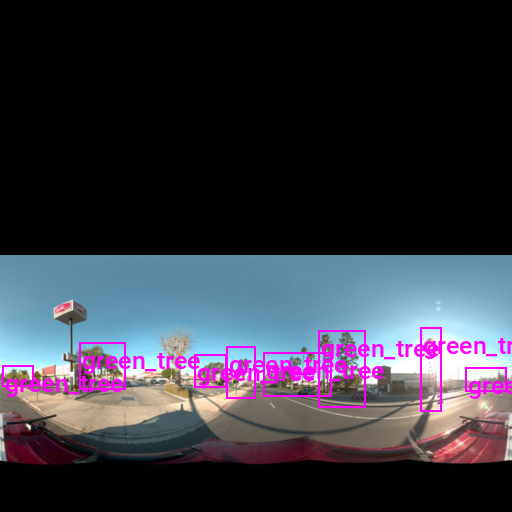

In [ ]:
from torchvision.transforms.v2 import Resize, SanitizeBoundingBoxes

# Ensure the padded image is the target size
resize = Resize([train_sz] * 2, antialias=True)

resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img),
    masks=targets['masks'],
    alpha=0.3,
    colors=sample_colors
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=targets['boxes'],
    labels=[class_names[int(label.item())] for label in targets['labels']],
    colors=sample_colors
)

# # Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')


#### Training Dataset Class

In [ ]:
class TreeDataset(Dataset):
    """
    This class represents a PyTorch Dataset for a collection of images and their annotations.
    The class is designed to load images along with their corresponding segmentation masks, bounding box annotations, and labels.
    """
    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Constructor for the TreeDataset class.

        Parameters:
        img_keys (list): List of unique identifiers for images.
        annotation_df (DataFrame): DataFrame containing the image annotations.
        img_dict (dict): Dictionary mapping image identifiers to image file paths.
        class_to_idx (dict): Dictionary mapping class labels to indices.
        transforms (callable, optional): Optional transform to be applied on a sample.
        """

        super(Dataset, self).__init__()

        self._img_keys = img_keys  # List of image keys
        self._annotation_df = annotation_df  # DataFrame containing annotations
        self._img_dict = img_dict  # Dictionary mapping image keys to image paths
        self._class_to_idx = class_to_idx  # Dictionary mapping class names to class indices
        self._transforms = transforms  # Image transforms to be applied

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        int: The number of items in the dataset.
        """
        return len(self._img_keys)

    def __getitem__(self, index):
        """
        Fetch an item from the dataset at the specified index.

        Parameters:
        index (int): Index of the item to fetch from the dataset.

        Returns:
        tuple: A tuple containing the image and its associated target (annotations).
        """
        # Retrieve the key for the image at the specified index
        img_key = self._img_keys[index]

        # Get the annotations for this image
        annotation = self._annotation_df.loc[img_key]

        # Load the image and its target (segmentation masks, bounding boxes and labels)
        image, target = self._load_image_and_target(annotation)

        # Apply the transformations, if any
        if self._transforms:
            image, target = self._transforms(image, target)

        return image, target

    def _load_image_and_target(self, annotation):
        """
        Load an image and its target (bounding boxes and labels).

        Parameters:
        annotation (pandas.Series): The annotations for an image.

        Returns:
        tuple: A tuple containing the image and a dictionary with 'boxes' and 'labels' keys.
        """
        # Retrieve the file path of the image
        filepath = self._img_dict[annotation.name]

        # Open the image file and convert it to RGB
        image = Image.open(filepath).convert('RGB')

        # Convert the class labels to indices
        labels = [shape['label'] for shape in annotation['shapes']]
        labels = torch.Tensor([self._class_to_idx[label] for label in labels])
        labels = labels.to(dtype=torch.int64)

        # Convert polygons to mask images
        shape_points = [shape['points'] for shape in annotation['shapes']]
        xy_coords = [[tuple(p) for p in points] for points in shape_points]
        mask_imgs = [create_polygon_mask(image.size, xy) for xy in xy_coords]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))

        # Generate bounding box annotations from segmentation masks
        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=image.size[::-1])

        return image, {'masks': masks,'boxes': bboxes, 'labels': labels}


In [ ]:
# from torchvision import transforms
from torchvision.transforms.v2 import Compose
import torchvision.transforms.v2  as transforms

# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# # Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms,
    resize_pad_tfm,
    final_tfms
])

valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])


In [ ]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the datasets using the defined transformations
train_dataset = TreeDataset(train_keys, annotation_df, img_dict, class_to_idx, train_tfms)
valid_dataset = TreeDataset(val_keys, annotation_df, img_dict, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')


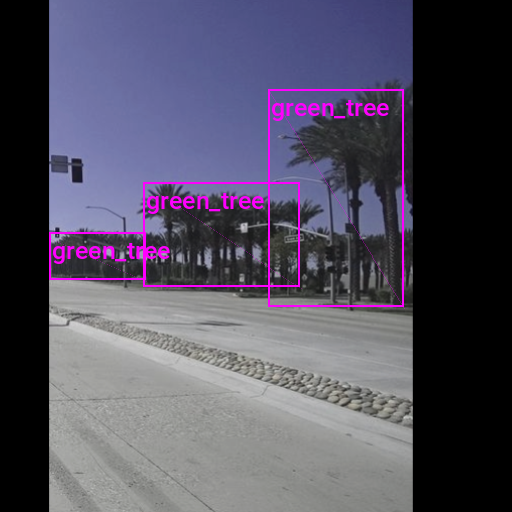

In [ ]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=(dataset_sample[0]*255).to(dtype=torch.uint8),
    masks=dataset_sample[1]['masks'],
    alpha=0.3,
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=dataset_sample[1]['boxes'],
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']],
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

In [ ]:
# Set the training batch size
bs = 4

# Set the number of worker processes for loading data.
num_workers = multiprocessing.cpu_count()//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    # 'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    # 'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'pin_memory': 'cuda',  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': 'cuda',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.

    'collate_fn': lambda batch: tuple(zip(*batch)),
}
# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
pd.Series({
    'Number of batches in train DataLoader:': len(train_dataloader),
    'Number of batches in validation DataLoader:': len(valid_dataloader)}
).to_frame().style.hide(axis='columns')



#### Fine-tuning the Model
Define the Training Loop

In [ ]:
def run_epoch(model, dataloader, optimizer, lr_scheduler, device, scaler, epoch_id, is_training):
    """
    Function to run a single training or evaluation epoch.

    Args:
        model: A PyTorch model to train or evaluate.
        dataloader: A PyTorch DataLoader providing the data.
        optimizer: The optimizer to use for training the model.
        loss_func: The loss function used for training.
        device: The device (CPU or GPU) to run the model on.
        scaler: Gradient scaler for mixed-precision training.
        is_training: Boolean flag indicating whether the model is in training or evaluation mode.

    Returns:
        The average loss for the epoch.
    """
    # Set the model to training mode
    model.train()

    epoch_loss = 0  # Initialize the total loss for this epoch
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")  # Initialize a progress bar

    # Loop over the data
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device
        inputs = torch.stack(inputs).to(device)

        # Forward pass with Automatic Mixed Precision (AMP) context manager
        with autocast(torch.device(device).type):
            if is_training:
                losses = model(inputs.to(device), move_data_to_device(targets, device))
            else:
                with torch.no_grad():
                    losses = model(inputs.to(device), move_data_to_device(targets, device))

            # Compute the loss
            loss = sum([loss for loss in losses.values()])  # Sum up the losses

        # If in training mode, backpropagate the error and update the weights
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        # Update the total loss
        loss_item = loss.item()
        epoch_loss += loss_item

        # Update the progress bar
        progress_bar_dict = dict(loss=loss_item, avg_loss=epoch_loss/(batch_id+1))
        if is_training:
            progress_bar_dict.update(lr=lr_scheduler.get_last_lr()[0])
        progress_bar.set_postfix(progress_bar_dict)
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    # Cleanup and close the progress bar
    progress_bar.close()

    # Return the average loss for this epoch
    return epoch_loss / (batch_id + 1)

def train_loop(model,
               train_dataloader,
               valid_dataloader,
               optimizer,
               lr_scheduler,
               device,
               epochs,
               checkpoint_path,
               use_scaler=False):
    """
    Main training loop.

    Args:
        model: A PyTorch model to train.
        train_dataloader: A PyTorch DataLoader providing the training data.
        valid_dataloader: A PyTorch DataLoader providing the validation data.
        optimizer: The optimizer to use for training the model.
        lr_scheduler: The learning rate scheduler.
        device: The device (CPU or GPU) to run the model on.
        epochs: The number of epochs to train for.
        checkpoint_path: The path where to save the best model checkpoint.
        use_scaler: Whether to scale graidents when using a CUDA device

    Returns:
        None
    """
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')  # Initialize the best validation loss

    # Loop over the epochs
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run a training epoch and get the training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, lr_scheduler, device, scaler, epoch, is_training=True)

        # Run an evaluation epoch and get the validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, None, device, scaler, epoch, is_training=False)

        # If the validation loss is lower than the best validation loss seen so far, save the model checkpoint
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

            # Save metadata about the training process
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

In [ ]:
project_name = 'maskrcnn'
# The path for the project folder
project_dir = Path(f"./{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

model.name = "MaskRCNN_custom"

In [ ]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

maskrcnn/2025-04-26_04-54-44/MaskRCNN_custom.pth


In [ ]:
# Create a color map and write it to a JSON file
import json
from pathlib import Path

dataset_path = Path(dataset_path)

color_map = {'items': [{'label': label, 'color': color} for label, color in zip(class_names, colors)]}
with open(f"{checkpoint_dir}/{dataset_path.name}-colormap.json", "w") as file:
    json.dump(color_map, file)

# Print the name of the file that the color map was written to
print(f"{checkpoint_dir}/{dataset_path.name}-colormap.json")

maskrcnn/2025-04-26_04-54-44/green_images_Diamond_bar_Labelme-colormap.json


In [ ]:
# Learning rate for the model
lr = 5e-4

# Number of training epochs
epochs = 40

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                   max_lr=lr,
                                                   total_steps=epochs*len(train_dataloader))

In [ ]:
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

<ipython-input-34-a22a2ea20ad6>:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' and use_scaler else None
Train: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s, loss=1.48, avg_loss=1.63, lr=2.82e-5]

Train: 100%|██████████| 24/24 [00:14<00:00,  1.67it/s, loss=1.01, avg_loss=0.995, lr=5.24e-5]

Train: 100%|██████████| 24/24 [00:14<00:00,  1.66it/s, loss=0.887, avg_loss=0.802, lr=9.08e-5]

Train: 100%|██████████| 24/24 [00:15<00:00,  1.59it/s, loss=0.727, avg_loss=0.816, lr=0.000141]

Train: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s, loss=1.18, avg_loss=0.783, lr=0.000199]

Train: 100%|██████████| 24/24 [00:14<00:00,  1.63it/s, loss=1.04, avg_loss=0.766, lr=0.000261]

Train: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s, loss=1.01, avg_loss=0.804, lr=0.000324]

Train: 100%|██████████| 24/24 [00:15<00:00,  1.56it/s, loss=0.815, avg_loss=0

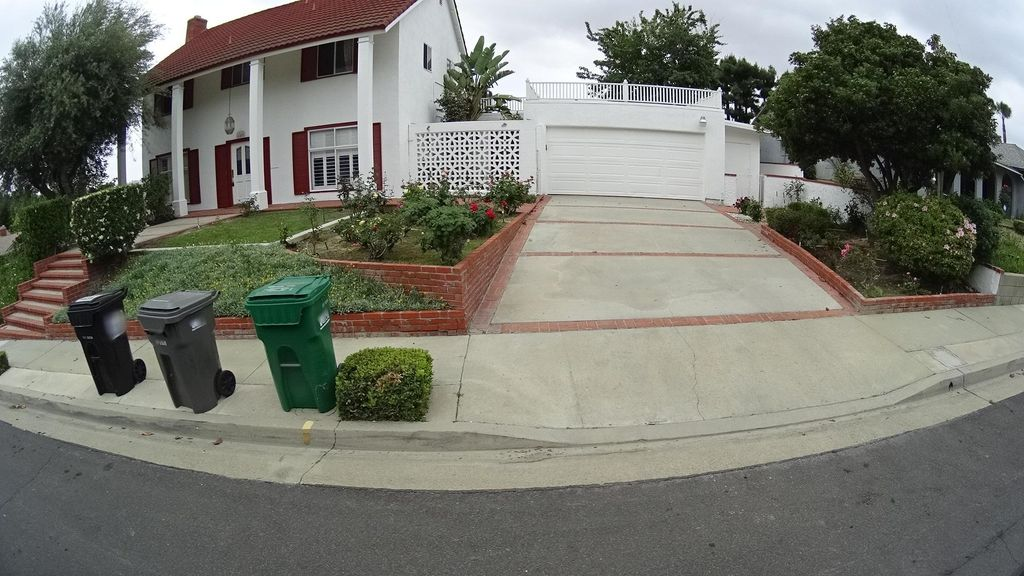

In [ ]:
# Choose a random item from the validation set
file_id = random.choice(val_keys)

# Retrieve the image file path associated with the file ID
test_file = img_dict[file_id]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Resize the test image
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(test_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')


In [ ]:
# Extract the polygon points for segmentation mask
target_shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
target_xy_coords = [[tuple(p) for p in points] for points in target_shape_points]
# Generate mask images from polygons
target_mask_imgs = [create_polygon_mask(test_img.size, xy) for xy in target_xy_coords]
# Convert mask images to tensors
target_masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in target_mask_imgs]))

# Get the target labels and bounding boxes
target_labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
target_bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(target_masks), format='xyxy', canvas_size=test_img.size[::-1])

In [ ]:
# Set the model to evaluation mode
model.eval();

# Ensure the model and input data are on the same device
model.to(device)
input_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])(input_img)[None].to(device)

# Make a prediction with the model
with torch.no_grad():
    model_output = model(input_tensor)

In [ ]:
# Set the confidence threshold
threshold = 0.5

# Move model output to the CPU
model_output = move_data_to_device(model_output, 'cpu')

# Filter the output based on the confidence threshold
scores_mask = model_output[0]['scores'] > threshold

# Scale the predicted bounding boxes
pred_bboxes = BoundingBoxes(model_output[0]['boxes'][scores_mask]*min_img_scale, format='xyxy', canvas_size=input_img.size[::-1])

# Get the class names for the predicted label indices
pred_labels = [class_names[int(label)] for label in model_output[0]['labels'][scores_mask]]

# Extract the confidence scores
pred_scores = model_output[0]['scores']

# Scale and stack the predicted segmentation masks
pred_masks = F.interpolate(model_output[0]['masks'][scores_mask], size=test_img.size[::-1])
pred_masks = torch.concat([Mask(torch.where(mask >= threshold, 1, 0), dtype=torch.bool) for mask in pred_masks])

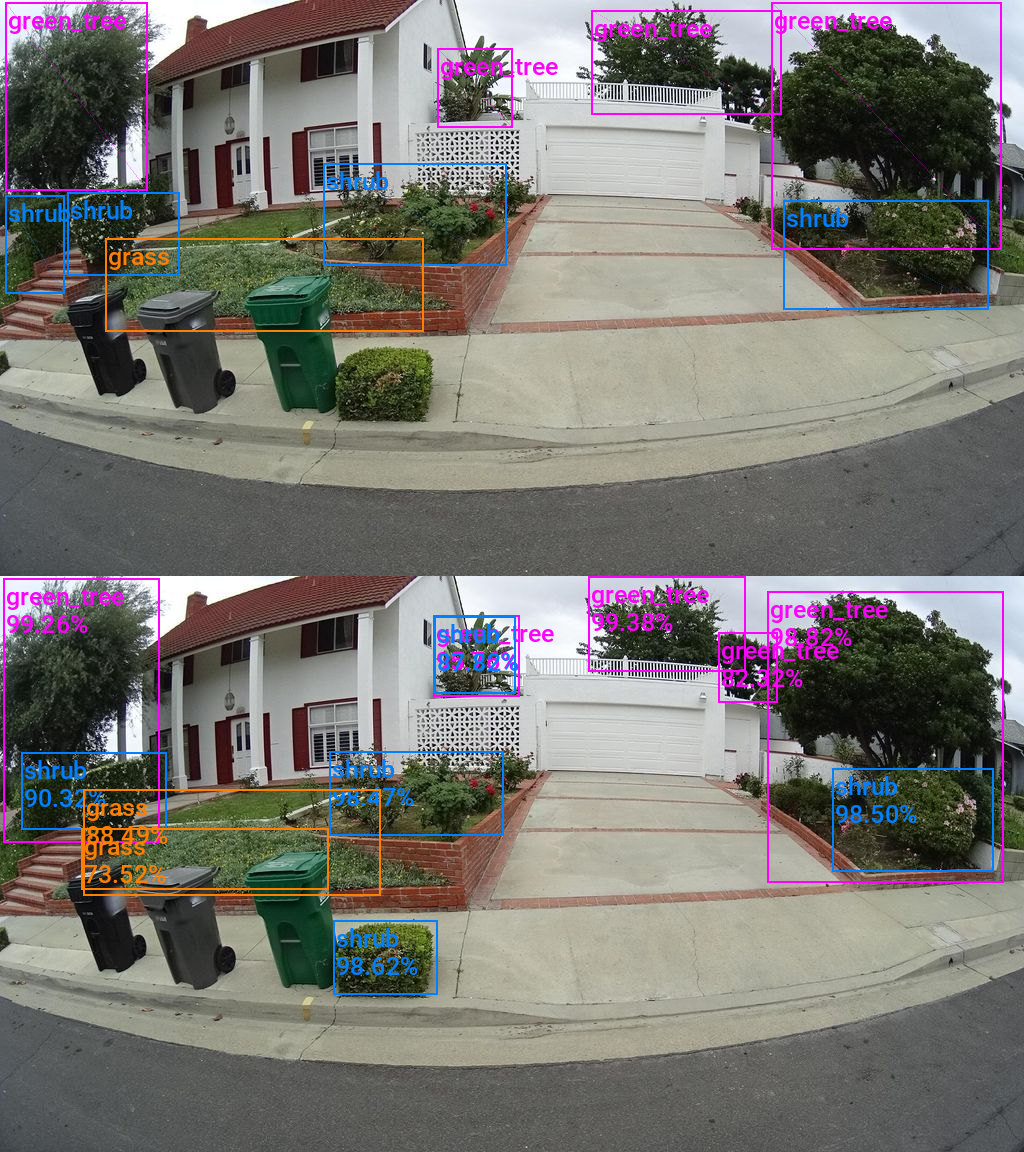

In [ ]:
# Get the annotation colors for the targets and predictions
target_colors=[int_colors[i] for i in [class_names.index(label) for label in target_labels]]
pred_colors=[int_colors[i] for i in [class_names.index(label) for label in pred_labels]]

# Convert the test images to a tensor
img_tensor = transforms.PILToTensor()(test_img)

# Annotate the test image with the target segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=target_masks, alpha=0.3, colors=target_colors)
# Annotate the test image with the target bounding boxes
annotated_tensor = draw_bboxes(image=annotated_tensor, boxes=target_bboxes, labels=target_labels, colors=target_colors)
# Display the annotated test image
annotated_test_img = tensor_to_pil(annotated_tensor)

# Annotate the test image with the predicted segmentation masks
annotated_tensor = draw_segmentation_masks(image=img_tensor, masks=pred_masks, alpha=0.3, colors=pred_colors)
# Annotate the test image with the predicted labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor,
    boxes=pred_bboxes,
    labels=[f"{label}\n{prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)],
    colors=pred_colors
)

# Display the annotated test image with the predicted bounding boxes
display(stack_imgs([annotated_test_img, tensor_to_pil(annotated_tensor)]))

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Target BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(target_labels, np.round(target_bboxes.numpy(), decimals=3))],
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(pred_labels, pred_bboxes.round(decimals=3).numpy())],
    "Confidence Scores:": [f"{label}: {prob*100:.2f}%" for label, prob in zip(pred_labels, pred_scores)]
}).to_frame().style.hide(axis='columns')